# PREDICCIÓN DEL CONSUMO DE ENERGÍA USANDO REDES LSTM

## 1 - ¿Qué es una serie de tiempo?

Es una secuencia de datos numéricos organizados cronológicamente. Estos datos usualmente se obtienen a intervalos regulares (cada mes, cada día, cada hora, cada segundo, etc.).

![](https://machinelearningmastery.com/wp-content/uploads/2016/11/Minimum-Daily-Temperatures.png)

(*Imagen tomada de machinelearningmastery.com*)

## 2 - El problema a resolver

Queremos desarrollar un modelo que sea capaz de aprender el patrón de comportamiento en una serie de tiempo (la demanda de Energía Eléctrica) en una región de Estados Unidos, y que posteriormente logre predecir cómo se comportará esta demanda en un futuro cercano.

![](https://drive.google.com/uc?export=view&id=1UaTeYJVVeHxA2nUX2d9tQIZJ8TiDPEAt)

## 3 - El set de datos

El dataset proviene de una empresa distribuidora de Energía Eléctrica en Estados Unidos (PJM Interconnection LLC), y contiene el comportamiento histórico de la demanda (en MegaWatts) entre los años 2004 y 2018 para la ciudad de Dayton (Ohio). Los registros se realizaron con una periodicidad de 1 hora.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd

ruta = '/gdrive/MyDrive/Colab Notebooks/01_2021-07-FundamentosDL/3.14-3.16-LSTM-ProyectoFinal-SeriesDeTiempo/DAYTON_hourly_2004_2018.csv'

# Leer el set de datos
datos = pd.read_csv(ruta, index_col=0, parse_dates=True)
datos.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0


In [ ]:
datos.shape

(121275, 1)

In [ ]:
# Y organizar cronológicamente
datos.sort_index(inplace=True)

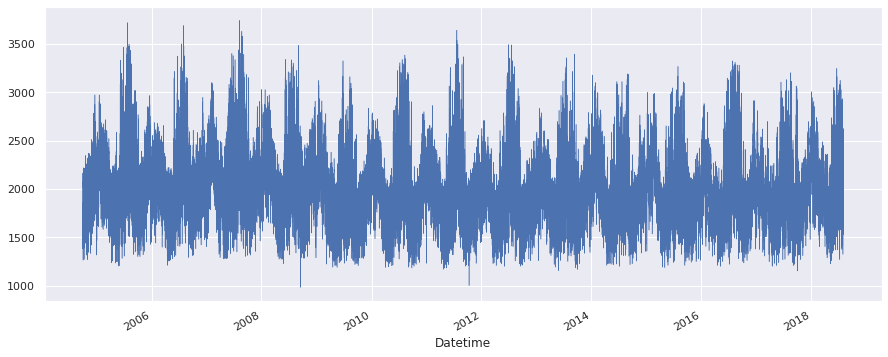

In [ ]:
# Veamos cómo son los datos
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 6)})
datos['DAYTON_MW'].plot(linewidth=0.5);

## 4 - Sets de entrenamiento y prueba

Como entrada al modelo usaremos bloques de 200 datos consecutivos (`X_train`) y el modelo deberá aprender a predecir el dato 201 de la secuencia (`Y_train`):

![](https://drive.google.com/uc?export=view&id=1_VqvozHTfjVrzzJzBAII3pIendriES40)

In [ ]:
import numpy as np

DATOS = datos['DAYTON_MW'].values

# Primero dividamos los sets entre train y test
# En este caso la partición no puede ser aleatoria
# (se debe preservar el orden de la secuencia)
TRAIN_SIZE = 0.9
idx = round(len(DATOS)*TRAIN_SIZE)
datos_train = DATOS[0:idx]
datos_test = DATOS[idx:]

In [ ]:
datos_train.reshape(-1,1).shape

(109148, 1)

In [ ]:
# Y ahora escalemos los datos entre -1 y 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
datos_train_s = scaler.fit_transform(datos_train.reshape(-1,1))
datos_test_s = scaler.transform(datos_test.reshape(-1,1))

In [ ]:
# Sets de entrenamiento y prueba
LONG_SEC = 200

X_train, Y_train = [], []
for i in range(len(datos_train_s)-LONG_SEC):
  X_train.append(datos_train_s[i:i+LONG_SEC])
  Y_train.append(datos_train_s[i+LONG_SEC])

X_test, Y_test = [], []
for i in range(len(datos_test_s)-LONG_SEC):
  X_test.append(datos_test_s[i:i+LONG_SEC])
  Y_test.append(datos_test_s[i+LONG_SEC])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(108948, 200, 1) (108948, 1)
(11927, 200, 1) (11927, 1)


In [ ]:
# Un ejemplo de entrenamiento:

ID = 623
print(f'Ejemplo {ID}:')
print(f'   Entrada: {X_train[ID,:,:].T}')
print(f'   Salida: {Y_train[ID]}')

Ejemplo 623:
   Entrada: [[-0.42691751 -0.51881331 -0.58321274 -0.5984081  -0.60998553 -0.58393632
  -0.4934877  -0.30318379 -0.15484805 -0.13096961 -0.12735166 -0.11360347
  -0.12228654 -0.12590449 -0.12662808 -0.14109986 -0.1642547  -0.16063676
  -0.16497829 -0.13314038 -0.0853835  -0.11505065 -0.17583213 -0.29232996
  -0.41027496 -0.50217077 -0.55065123 -0.57597685 -0.5853835  -0.56150507
  -0.47178003 -0.28075253 -0.14037627 -0.14327062 -0.1447178  -0.13748191
  -0.15050651 -0.15484805 -0.15195369 -0.16353111 -0.18668596 -0.18596237
  -0.20332851 -0.20911722 -0.14327062 -0.14833575 -0.19826339 -0.30824891
  -0.4146165  -0.49565847 -0.52749638 -0.55571635 -0.57380608 -0.54920405
  -0.46599132 -0.28002894 -0.12662808 -0.10781476 -0.11505065 -0.08900145
  -0.07091172 -0.08393632 -0.10347323 -0.11070912 -0.12373372 -0.1316932
  -0.16497829 -0.15701881 -0.12228654 -0.1577424  -0.22141823 -0.31114327
  -0.42547033 -0.52532562 -0.59768452 -0.63531114 -0.64399421 -0.65918958
  -0.63748191 

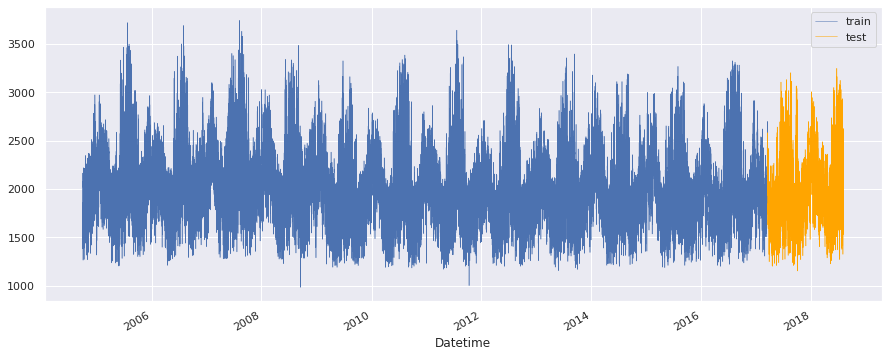

In [ ]:
datos['DAYTON_MW'].iloc[0:idx].plot(linewidth=0.5, label='train')
datos['DAYTON_MW'].iloc[idx:].plot(linewidth=0.5, color='orange', label='test')
plt.legend();

## 5 - Creación y entrenamiento del modelo

## 6 - Predicción

In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf